In [8]:
import json
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Load Training Data

In [9]:
def read_data(filename):
    with open(filename) as data_file:    
        data = json.load(data_file)
    
    return data

In [10]:
train_file = 'data/train.json'
train_data = read_data(train_file)

## Prepare data

In [11]:
def find_minmax(data):
    mins = [min(min(item['band_1']), min(item['band_2'])) for item in data ]
    maxes = [max(max(item['band_1']), max(item['band_2'])) for item in data ]

    global_min = min(mins)
    global_max = max(maxes)
    
    return global_min, global_max

def extract_image(data_item, key, min_value, max_value, image_size = 75):
    image = np.array(data_item[key])
    image = image.reshape(image_size, image_size)

    image = (image - global_min) / (global_max - global_min)
    
    return image
    
def extract_images(data_item, min_value, max_value, image_size = 75):
    hh_image = extract_image(data_item, 'band_1', min_value, max_value, image_size)
    hv_image = extract_image(data_item, 'band_2', min_value, max_value, image_size)
    
    return hh_image, hv_image
     
def display_image(image):
    plt.imshow(image, cmap='gray')
    plt.show()

In [69]:
def prepare_dataset_ignore_angle(data, global_min, gobal_max):
    X =[]
    labels = []
    ids = []
    
    for item in data:
        hh_image, hv_image = extract_images(item, global_min, gobal_max )
        image = np.dstack((hh_image, hv_image))
        X.append(image)
        if 'is_iceberg' in item.keys():
            labels.append(item['is_iceberg'])
        else:
            labels.append(0)
            
        ids.append(item['id'])
    return np.array(X), np.array(labels), np.array(ids)

In [70]:
def cut_image_part(data, margin):
    return data[:, margin : -margin, margin : - margin, :]

-45.655499 34.574917


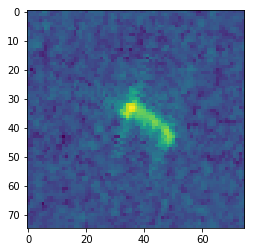

In [71]:
image_size = 75
global_min, global_max = find_minmax(train_data)

X_train, y_train, _ = prepare_dataset_ignore_angle(train_data, global_min, global_max)

print(global_min, global_max)


plt.imshow(X_train[24, :, :, 0])
plt.show()


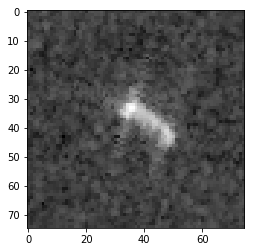

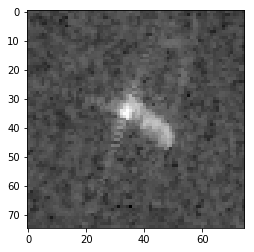

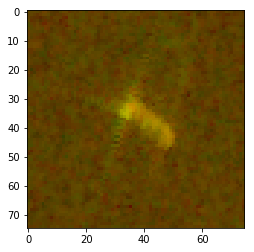

In [72]:
hh_image, hv_image = extract_images(train_data[24], global_min, global_max )
display_image(hh_image)
display_image(hv_image)

image = np.dstack((hh_image, hv_image, np.zeros_like(hv_image)))
plt.imshow(image)
plt.show()

(1604, 75, 75, 2)


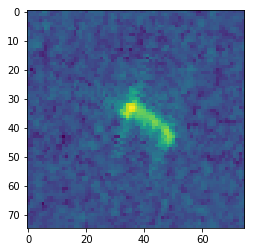

In [73]:
print(X_train.shape)

plt.imshow(X_train[24, :, :, 0])
plt.show()


C:\Users\Alexey\AppData\Local\conda\conda\envs\aind-cv\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (1604, 75, 75, 2) (2 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')
C:\Users\Alexey\AppData\Local\conda\conda\envs\aind-cv\lib\site-packages\keras\preprocessing\image.py:787: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (1604, 75, 75, 2) (2 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


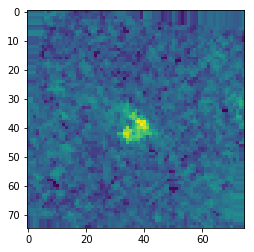

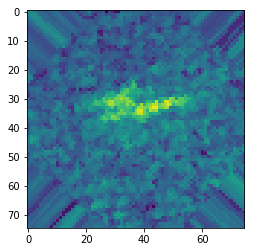

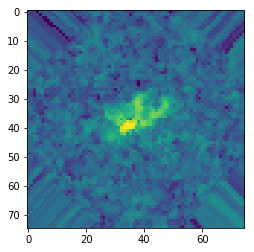

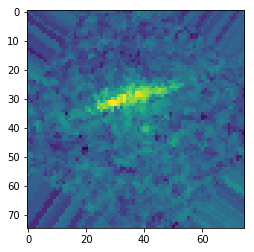

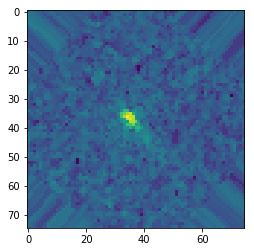

(1604, 75, 75, 2)
(1604, 75, 75, 2)
(9624, 75, 75, 2)


In [74]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=90)
datagen.fit(X_train)

X_train_new = np.copy(X_train)
Y_train_new = np.copy(y_train)

for i in range(5):
    X_batch, y_batch =  next(datagen.flow(X_train, y_train, batch_size=3000))
    X_train_new = np.concatenate((X_train_new, X_batch), axis=0)
    Y_train_new = np.concatenate((Y_train_new, y_batch), axis=0)
    
    plt.imshow(X_batch[24, :, :, 0])
    plt.show()
                                    
    
print(X_batch.shape)


print (X_batch.shape)
#X_train = cut_image_part(X_train_new, 10)
print (X_train_new.shape)







## Model

In [79]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Activation, BatchNormalization
from keras.layers import Flatten, Dense
from keras.initializers import RandomNormal

entities_count = 30

def getModel10():
    model = Sequential()
    model.add(Convolution2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same',
                    input_shape=(75, 75, 2), use_bias=True))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dense(1, activation="sigmoid"))
    
    return model


def getModel20():
    model = Sequential()
    model.add(Convolution2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same',
                    input_shape=(75, 75, 2), use_bias=True))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    #model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True))
    #model.add(Activation('relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(1024, activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation="sigmoid"))
    
    return model

In [98]:
def getModel30():
    model = Sequential()
    model.add(Convolution2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same',
                    input_shape=(75, 75, 2), use_bias=True))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(512, activation="relu",
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation="relu",
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))
    
    return model

def getModel40():
    model = Sequential()
    model.add(Convolution2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same',
                     input_shape=(75, 75, 2), use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.04, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.04, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.04, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.04, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.04, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(1024, activation="relu",
                   kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Dropout(0.25))
    model.add(Dense(512, activation="relu",
                   kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation="sigmoid"))

    return model

In [99]:
model = getModel40()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 75, 75, 16)        288       
_________________________________________________________________
batch_normalization_25 (Batc (None, 75, 75, 16)        64        
_________________________________________________________________
activation_49 (Activation)   (None, 75, 75, 16)        0         
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 38, 38, 16)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 38, 38, 32)        4608      
_________________________________________________________________
batch_normalization_26 (Batc (None, 38, 38, 32)        128       
_________________________________________________________________
activation_50 (Activation)   (None, 38, 38, 32)        0         
__________

In [100]:
from keras.callbacks import ModelCheckpoint  

epochs = 50
train_tensors = X_train_new
train_targets = Y_train_new

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

res = model.fit(train_tensors, train_targets, 
          validation_split = 0.2,
          epochs=epochs, batch_size=64, callbacks=[checkpointer], verbose=1)

Train on 7699 samples, validate on 1925 samples
Epoch 1/50
7699/7699 [==============================] - 5s - loss: 0.5779 - acc: 0.7354 - val_loss: 0.7185 - val_acc: 0.4701
Epoch 2/50
7699/7699 [==============================] - 3s - loss: 0.3191 - acc: 0.8592 - val_loss: 0.7308 - val_acc: 0.3932
Epoch 3/50
7699/7699 [==============================] - 3s - loss: 0.2642 - acc: 0.8810 - val_loss: 0.9766 - val_acc: 0.4764
Epoch 4/50
7699/7699 [==============================] - 4s - loss: 0.2297 - acc: 0.9034 - val_loss: 1.4149 - val_acc: 0.5221
Epoch 5/50
7699/7699 [==============================] - 3s - loss: 0.2061 - acc: 0.9152 - val_loss: 0.6660 - val_acc: 0.7486
Epoch 6/50
7699/7699 [==============================] - 4s - loss: 0.1557 - acc: 0.9406 - val_loss: 0.2386 - val_acc: 0.8997
Epoch 7/50
7699/7699 [==============================] - 3s - loss: 0.1245 - acc: 0.9526 - val_loss: 0.8748 - val_acc: 0.7532
Epoch 8/50
7699/7699 [==============================] - 3s - loss: 0.1032 - a

C:\Users\Alexey\AppData\Local\conda\conda\envs\aind-cv\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.546291). Check your callbacks.
  % delta_t_median)
C:\Users\Alexey\AppData\Local\conda\conda\envs\aind-cv\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.274147). Check your callbacks.
  % delta_t_median)


7699/7699 [==============================] - 3s - loss: 0.0309 - acc: 0.9887 - val_loss: 0.4476 - val_acc: 0.9117
Epoch 15/50
7699/7699 [==============================] - 3s - loss: 0.0453 - acc: 0.9839 - val_loss: 0.4616 - val_acc: 0.8338
Epoch 16/50
7699/7699 [==============================] - 3s - loss: 0.0325 - acc: 0.9870 - val_loss: 0.3730 - val_acc: 0.9106
Epoch 17/50
7699/7699 [==============================] - 3s - loss: 0.0499 - acc: 0.9814 - val_loss: 0.4573 - val_acc: 0.8618
Epoch 18/50
7699/7699 [==============================] - 3s - loss: 0.0226 - acc: 0.9922 - val_loss: 0.4283 - val_acc: 0.8831
Epoch 19/50
7699/7699 [==============================] - 3s - loss: 0.0125 - acc: 0.9957 - val_loss: 0.4252 - val_acc: 0.9049
Epoch 20/50
7699/7699 [==============================] - 3s - loss: 0.0122 - acc: 0.9956 - val_loss: 0.9928 - val_acc: 0.8208
Epoch 21/50
7699/7699 [==============================] - 4s - loss: 0.0257 - acc: 0.9919 - val_loss: 1.6382 - val_acc: 0.6327
Epoc

C:\Users\Alexey\AppData\Local\conda\conda\envs\aind-cv\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.621898). Check your callbacks.
  % delta_t_median)
C:\Users\Alexey\AppData\Local\conda\conda\envs\aind-cv\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.311450). Check your callbacks.
  % delta_t_median)


7699/7699 [==============================] - 3s - loss: 0.0121 - acc: 0.9962 - val_loss: 0.3602 - val_acc: 0.9184
Epoch 39/50
7699/7699 [==============================] - 3s - loss: 0.0075 - acc: 0.9977 - val_loss: 0.5016 - val_acc: 0.9216
Epoch 40/50
7699/7699 [==============================] - 3s - loss: 0.0123 - acc: 0.9960 - val_loss: 0.6491 - val_acc: 0.8862
Epoch 41/50
7699/7699 [==============================] - 3s - loss: 0.0136 - acc: 0.9956 - val_loss: 0.4179 - val_acc: 0.9070
Epoch 42/50
7699/7699 [==============================] - 3s - loss: 0.0313 - acc: 0.9891 - val_loss: 0.7793 - val_acc: 0.8400
Epoch 43/50
7699/7699 [==============================] - 3s - loss: 0.0172 - acc: 0.9936 - val_loss: 0.3970 - val_acc: 0.8810
Epoch 44/50
7699/7699 [==============================] - 3s - loss: 0.0152 - acc: 0.9957 - val_loss: 0.6137 - val_acc: 0.8618
Epoch 45/50
7699/7699 [==============================] - 4s - loss: 0.0080 - acc: 0.9973 - val_loss: 1.0234 - val_acc: 0.8384
Epoc

AttributeError: 'numpy.ndarray' object has no attribute 'history'

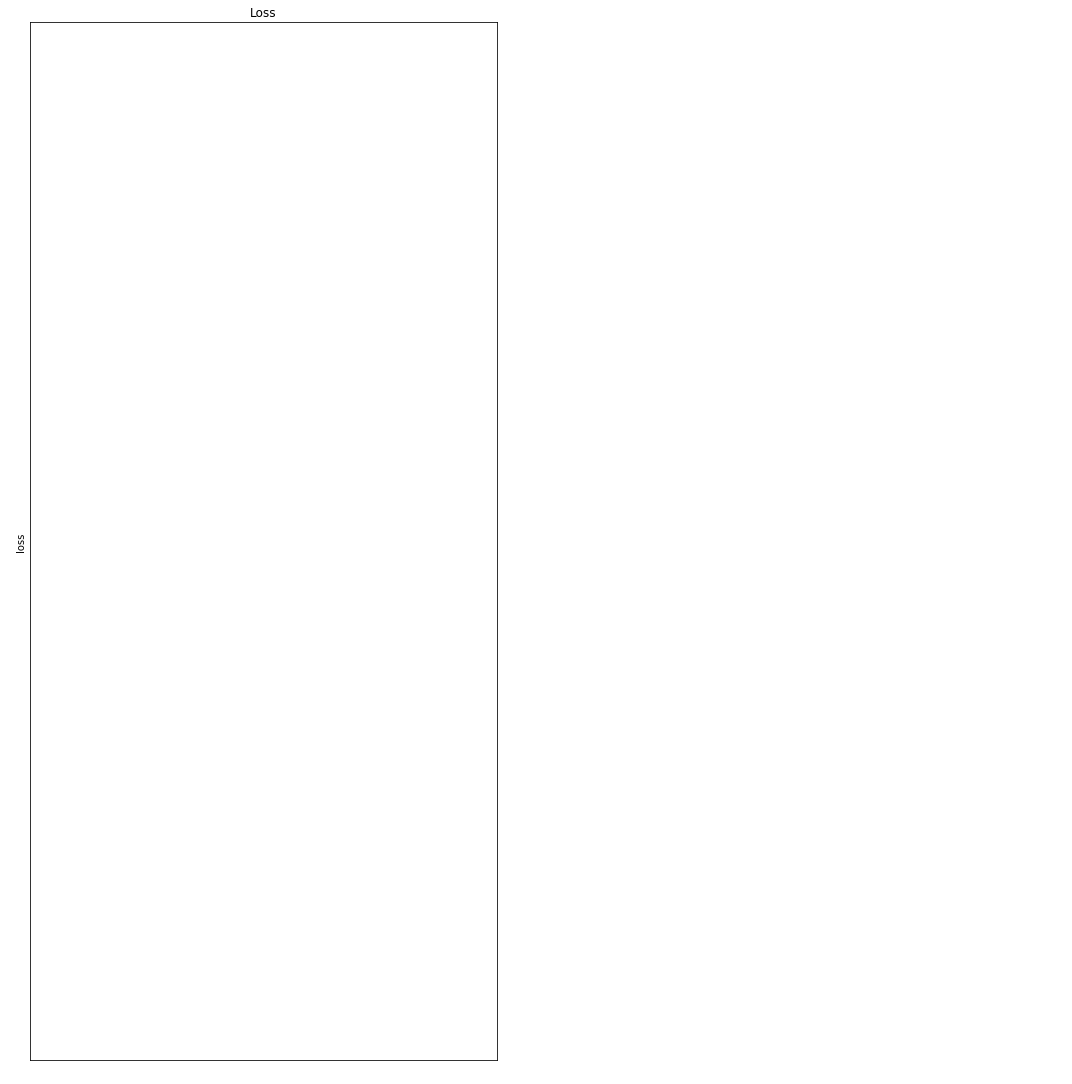

In [97]:
graphs = [res]

fig = plt.figure(figsize = (15, 15))
plt.axis('off')
plt.tight_layout()

for i, hist in enumerate(graphs):
    ax1 = fig.add_subplot(120 + i + 1)
    #plt.setp([ax1], xticks=[], yticks=[])
    ax1.set_ylim(0, 1.0)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_title("Loss")
    ax1.set_ylabel('loss')
    #ax1.set_xlabel('epoch')
    ax1.plot(hist.history['loss'])
    ax1.plot(hist.history['val_loss'])
    ax1.xaxis.set_ticks(np.arange(0, epochs, epochs // 10))
    ax1.yaxis.set_ticks(np.arange(0, 1, 0.2))


In [85]:
from keras.models import load_model

prediction_model = load_model('saved_models/weights.best.from_scratch.hdf5')


In [86]:
test_file = 'data/test.json'
test_data = read_data(test_file)


In [88]:
X_test, y_test, ids = prepare_dataset_ignore_angle(test_data, global_min, global_max)

In [89]:
print(X_test.shape)

(8424, 75, 75, 2)


In [90]:
res = model.predict(X_test)

In [91]:
print(res.shape)

(8424, 1)


In [92]:
print(y_test.shape)

(8424,)


In [93]:
print(y_test)

[0 0 0 ..., 0 0 0]


In [94]:
import csv
headers = ['id', 'is_iceberg']

with open('results.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile, quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(headers)

    for prediction, item_id in zip(res, ids):
        csv_writer.writerow([item_id, np.asscalar(prediction)])

    